# CMM262: RNA-sequencing, Day 2<br>Part 2 - (RNA-seq Differential Expression Analysis)

**Authors:** Michelle Franc Ragsac (mragsac@eng.ucsd.edu) and Eric Kofman (ekofman@eng.ucsd.edu)

> *Based on the DESeq R Markdown notebook from CMM262 taught in Winter 2020* 

Now that we've gone through the beginning of the RNA-sequencing analysis pipeline to transform our FASTQ sequencing data to, eventually, a counts matrix to show the number of reads we have for each gene in our experiment, we can use the `DESeq2` package in the R programming language to determine the *differentially expressed* genes present in our experiment. 

---

### Table of Contents

1. Performing Differential Expression Analyses with the `DESeq2` Library 
2. Defining Experimental Parameters for `DESeq2` and Constructing the `DESeqDataSet` Object
3. Performing Data Quality Control with Built-In `DESeq2` Methods

---

## Performing Differential Expression Analyses with the `DESeq2` Library 

> Love, Michael I., Wolfgang Huber, and Simon Anders. "Moderated estimation of fold change and dispersion for RNA-seq data with DESeq2." *Genome biology* 15.12 (2014): 550. https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0550-8

One of the most basic tasks in RNA-sequencing analysis is the detection of differentially expressed genes. Often, the count data that comes out of a command-line RNA-sequencing processing pipeline comes as a table that reports the number of sequence fragments (e.g., reads) that have been assigned to each gene of interest. 

However, there are some challenges that need to be considered when trying to assess quantitative differences between experiments: (i) biological count data is often *non-normal*, (ii) variance on the mean of count data can vary between samples, and (iii) there are often a small number of sample per condition to start off with! Because methods that treat each gene separately lack power due to the uncertainty of within-group variance estimates, many methods pool information across genes by exploiting assumptions about the similarity of the variances (or *dispersion*) of different genes measured in the same experiment. 

<div class="alert alert-block alert-info">
    <p>If you're interested in why it's important to normalize and model count data accurately, check out the following Jupyter Notebook that was presented at the 2020 BISB Bootcamp's <i>Introduction to Machine Learning</i> module taught by Cameron Martino: <a href="https://github.com/mragsac/BISB-Bootcamp-2020/blob/master/day4/module7_machine-learning-101/2.0-count-data-intro.ipynb">https://github.com/mragsac/BISB-Bootcamp-2020/blob/master/day4/module7_machine-learning-101/2.0-count-data-intro.ipynb</a>!</p>
</div>

Within this notebook, we'll be focusing on the popular software known as `DESeq2`. To tackle the problem of comparing counts data between different biological samples, `DESeq2` first models the raw counts that are observed using *normalization factors* (otherwise known as *size factors*) to account for differences in library depth. Then, it estimates the variability of all of the genes present (or *gene-wise dispersions*) and shrinks the estimates to generate more accurate representations of dispersion of model the raw counts. Finally, using a generalized linear model (GLM), `DESeq2` fits the data to a *negative binomial model* and performs hypothesis testing using the *Wald test* or *Likelihood Ratio Test* to determine differentally expressed genes.

This notebook will focus on giving you the basic commands to use `DESeq2` on your own data! We'll be using the human airway smooth muscle transcriptome dataset that we used in Day 3 of our statistics module for this demonstration: https://github.com/biom262/cmm262-2021/blob/main/module-2-statistics/Day%203%20-%20Gene%20Expression%20Analysis.ipynb.

<div class="alert alert-block alert-info">
    <p>Because <code>DESeq2</code> is a popular package for differential expression analysis in R, there are a lot of resources available for learning how to use the tool. Here are some of our favorites that we would recommend:</p>
    <ul>
        <li><b>Official DESeq2 Documentation</b>:<a href="https://bioconductor.org/packages/release/bioc/manuals/DESeq2/man/DESeq2.pdf">https://bioconductor.org/packages/release/bioc/manuals/DESeq2/man/DESeq2.pdf</a></li>
        <li><b>Official DESeq2 Vignette</b>:<a href="http://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html">http://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html</a></li>
        <li><b>Beginner's Guide to Using the DESeq2 Package by Love <i>et al.</i></b>:<a href="http://www.bioconductor.org/packages/2.14/bioc/vignettes/DESeq2/inst/doc/beginner.pdf">http://www.bioconductor.org/packages/2.14/bioc/vignettes/DESeq2/inst/doc/beginner.pdf</a></li>
    </ul>
</div>

### Import the Packages We'll be Using in this Portion of the Notebook

In [ ]:
# First, import/load in the DESeq2 library into our notebook
library(DESeq2)

# Next, import/load in the ggplot2 and RColorBrewer packages for result exploration
library(ggplot2)
library(RColorBrewer)

### Load in the RNA-Sequencing Dataset using the `read.csv()` Method on our Counts Matrix and Labels File

<div class="alert alert-block alert-info">
    <p>The values in the count matrix should be <b>un-normalized counts</b> or estimated counts of sequencing reads (for single-end RNA-sequencing data) or fragments (for paired-end RNA-sequencing data). It is important to provide count matrices for <code>DESeq2</code> for the software's statistical model to hold, as only the count values allow assessing the measurement precision correctly.</p>
    <p><code>DESeq2</code> internally corrects for library size, so transformed or normalized values such as counts scaled by library size should <b>not</b> be used as input!</p>
</div>

In [7]:
# Because DESeq2 works with raw count matrices and uses the row names as identifiers 
# for our genes, we'll import the data accordingly with the read.csv() method!
counts <- read.csv('data/asm_dex_counts.txt', 
                   sep = "\t",    # specify that our data is tab-delimited 
                   row.names = 1, # designate the row with gene names present
                   header = TRUE) # state that we have a header already present

# After importing in the data, let's preview the contents with the head() method
head(counts)

,A,B,E,F,I,J,M,N
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,667,434,862,401,1133,1050,750,562
ENSG00000000005,0,0,0,0,0,0,0,0
ENSG00000000419,430,488,556,334,529,719,378,468
ENSG00000000457,256,226,276,174,288,358,248,235
ENSG00000000460,56,52,29,30,63,53,68,56
ENSG00000000938,0,0,1,0,1,0,0,0


In [3]:
# We also need our condition identifiers so DESeq2 knows what groups to compare against each other 
col.data <- read.csv('data/asm_dex_labels.txt', sep = '\t', header = TRUE, row.names = 1)
head(col.data)

,condition
,<chr>
A,untreated
B,Dex
E,untreated
F,Dex
I,untreated
J,Dex


---

## Defining Experimental Parameters for `DESeq2` and Constructing the `DESeqDataSet` Object

The object class used by the `DESeq2` package to store the read counts and intermediate estimated quantities during statistical analysis is known as the `DESeqDataSet`, which is usually represented in code as the `dds` variable. 

One of the most important components is that the `DESeqDataSet` must have an associated *design formula*, provided by the `design` parameter. The design formula is used to estimate the dispersions and to estimate the $log_2$ fold changes of the model. The design formula expresses the variables that will be used in the modeling and should be a tilde (`~`) followed by the variables (if there are multiple variables, then they are connected by plus (`+`) signs). While the design can be changed later, it is recommended that all of the differential analysis steps be repeated if it is modified. 

<div class="alert alert-block alert-warning">
    <p>While there are multiple ways of constructing the <code>DESeqDataSet</code> depending on what the upstream steps were, we will be using the <code>DESeqDataSetFromMatrix()</code> method to provide count matrix input from our RNA-sequencing data processing pipeline that we performed earlier!</p>
</div>

<div class="alert alert-block alert-info">
    <p>If you have additional feature data, it can be added to the <code>DESeqDataSet</code> by adding to the metadata columns of a newly constructed object (e.g., you can add technical replicate or sample batch information in addition to the different sample conditions being tested).</p>
</div>

In [9]:
# Generate the DESeq2DataSet object using our counts matrix values and labels 
dds <- DESeqDataSetFromMatrix(countData = counts,   # specify the counts matrix to use 
                              colData = col.data,   # specify our sample groupings 
                              design = ~ condition) # state we would like to model the condition of our groupings

# Now that we've generate the DESeq2DataSet object, let's preview the contents of the object!
dds 

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 57773 8 
metadata(1): version
assays(1): counts
rownames(57773): ENSG00000000003 ENSG00000000005 ... ENSG00000273492
  ENSG00000273493
rowData names(0):
colnames(8): A B ... M N
colData names(1): condition

---

## Performing Data Quality Control with Built-In `DESeq2` Methods

### Applying a Regularized Log-Transformation with the `rlog()` Method

Within RNA-sequencing data, we see the phenomenon that within a dataset, there are a few genes that have very strong expression and these genes are often outnumbered by the genes with low or moderate expression. This makes it difficult to reduce the dimensionality of RNA-sequencing datasets with common statistical methods, such as principal component analysis (PCA), without performing an additional transformation step beforehand. A common transformation step is to take the logarithm of normalized count values plus a small pseudocount; however, due to the strong Poisson noise inherent to small count values, this leads genes with low counts to dominate the results! 

As a solution, `DESeq2` uses a method called the *regularized-logarithm transformation*, found in the `rlog()` function. For genes with high counts, the `rlog()` function does not differ much from a regular $log_2$ transformation. However, for genes with lower counts, the values are *shrunken* towards the genes' averages across all samples! 

<div class="alert alert-block alert-info">
    <p>The regularized-logarithm transformation <b>should not</b> be used for differential testing. Again, is recommended that you use raw counts for the differential testing methods offered by <code>DESeq2</code>.</p>
</div>

In [10]:
rld <- rlog(dds)

### Visualizing Sample Separation with Principal Component Analysis (PCA) via the `plotPCA()` Method

A useful step within RNA-sequencing analyses is to evaluate the overall similarity between samples: which samples are different versus similar to each other? One way to visualize these differences is using principal component analysis, or PCA. Within this method, the data points are projected into two-dimensional space such that they're able to spread out according to their variances across different axes. The `plotPCA()` function provides an easy way to visualize these differences!

In [17]:
data <- plotPCA(rld, intgroup = 'condition', returnData = TRUE)
percent.var <- round(100 * attr(data, 'percentVar'))

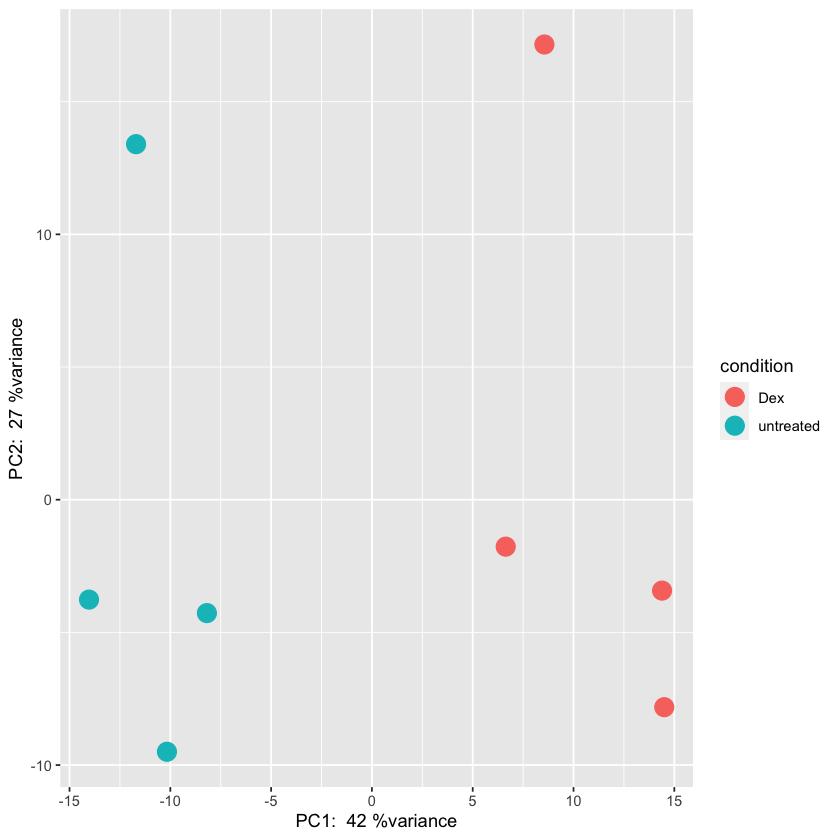

In [7]:
# Calculate the PCA dimensionality reduction of our samples with the plotPCA() method
data <- plotPCA(rld, intgroup = 'condition', returnData = TRUE)

# Calculate the variance that is captured by each principal component
percent.var <- round(100 * attr(data, 'percentVar'))

# Generate the PCA plot with ggplot
ggplot(data, aes(x = PC1, y = PC2, color = condition)) +
    geom_point(size = 5) + 
    xlab(paste("PC1: ", percent.var[1], "%variance")) +
    ylab(paste("PC2: ", percent.var[2], "%variance"))

### Visualizing Sample Similarities with a Heatmap using the `heatmap()` Method

In [8]:
sample.distances <- dist(t(assay(rld)))
sample.distances.matrix <- as.matrix(sample.distances)

rownames(sample.distances.matrix) <- paste(rld$condition)
colnames(sample.distances.matrix) <- paste(rld$condition)

head(sample.distances.matrix)

,untreated,Dex,untreated,Dex,untreated,Dex,untreated,Dex
untreated,0.00000,38.82009,34.38693,52.71237,39.01658,54.56547,33.66636,52.88493
Dex,38.82009,0.00000,46.96040,38.35728,50.26043,44.15732,48.29535,38.09316
untreated,34.38693,46.96040,0.00000,41.70397,37.81243,50.20205,31.88092,48.65253
Dex,52.71237,38.35728,41.70397,0.00000,53.97869,42.99183,49.61908,31.73246
untreated,39.01658,50.26043,37.81243,53.97869,0.00000,40.22005,40.37543,55.29568
Dex,54.56547,44.15732,50.20205,42.99183,40.22005,0.00000,54.06597,44.95592


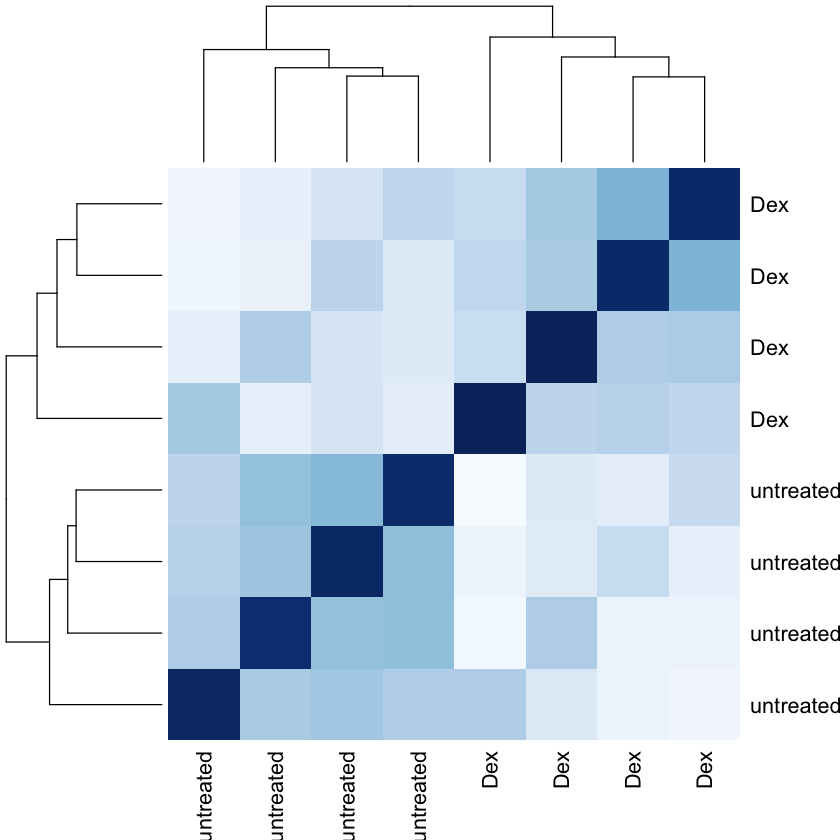

In [9]:
colors <- colorRampPalette(rev(brewer.pal(9, 'Blues')))(255)

heatmap(sample.distances.matrix,
        col = colors)

---

## Perform Differential Expression Analysis on our Dataset

In [10]:
dds.result <- DESeq(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [11]:
result <- results(dds.result)
head(as.data.frame(result))
summary(result)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003,698.9254902,0.39153380,0.1772775,2.2085930,0.02720296,0.1279430
ENSG00000000005,0.0000000,NA,NA,NA,NA,NA
ENSG00000000419,475.4853185,-0.21430314,0.1009322,-2.1232393,0.03373380,0.1492131
ENSG00000000457,251.9014951,-0.01449455,0.1133820,-0.1278382,0.89827700,0.9638248
ENSG00000000460,50.8475599,0.05771268,0.3491227,0.1653078,0.86870176,0.9528764
ENSG00000000938,0.2129756,1.23581072,3.5287813,0.3502089,0.72618190,NA



out of 28730 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1502, 5.2%
LFC < 0 (down)     : 1809, 6.3%
outliers [1]       : 41, 0.14%
low counts [2]     : 11602, 40%
(mean count < 4)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [12]:
result <- result[order(result$padj),]
head(as.data.frame(result))

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000152583,985.5593,-4.635709,0.21308039,-21.75568,6.103424e-105,1.042892e-100
ENSG00000125148,1882.4064,-2.126464,0.11661527,-18.23487,2.729154e-74,2.331652e-70
ENSG00000148175,13193.7455,-1.415616,0.08802295,-16.08235,3.392734e-58,1.932388e-54
ENSG00000179094,763.9862,-3.226080,0.20219085,-15.95562,2.603849e-57,1.112299e-53
ENSG00000134686,2789.5345,-1.381157,0.09094597,-15.18656,4.340817e-52,1.483431e-48
ENSG00000109906,362.6725,-7.391204,0.48792688,-15.14818,7.789365e-52,2.218281e-48


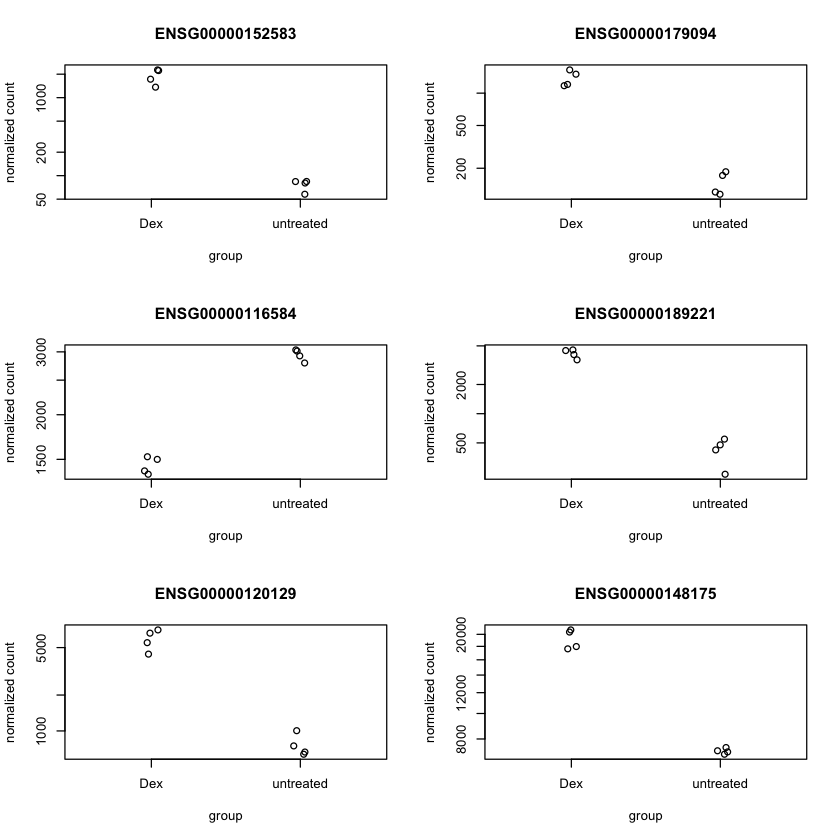

In [13]:
par(mfrow=c(3,2))

plotCounts(dds, gene="ENSG00000152583")
plotCounts(dds, gene="ENSG00000179094")
plotCounts(dds, gene="ENSG00000116584")
plotCounts(dds, gene="ENSG00000189221")
plotCounts(dds, gene="ENSG00000120129")
plotCounts(dds, gene="ENSG00000148175")

---

## Generating MA-Plots to Determine the Differences between Samples

MA plots are a way to visualize gene expression datasets in two dimensions, and are especially useful for experiments with two-group comparisons. Within a MA plot, each gene is reprsented as a single dot. The x-axis is the average expression across all samples, and the y-axis represents the $log_2$ fold change between the two conditions being observed (e.g., control versus dex-treated samples). Genes with an adjusted p-value below some threshold are then shown in red. 

Generally, **genes with similar expression values in both conditions will cluster around `M=0`, whereas points away from `M=0` indicate genes that have significant expression.** Genes above `M=0` are considered to be *upregulated*, whereas genes below `M=0` are considered to be *downregulated*. It is also important to note that `DESeq2` has a specific way for how it considered log fold changes: when count values are too low to allow for an accurate estimation of the log fold change, the value is "shrunken" towards `0` to avoid overestimation of its ranking across all genes. 

<div class="alert alert-block alert-info">
    <p>MA plots demonstrate that only genes with a *large* average normalized count contain sufficient information to yield a significant call. That is, for weakly expressed genes, we have no chance at seeing differential expression because the low read counts suffer from so much noise that any biological effect is drowned out by uncertainties in read counting.</p>
</div>

In [ ]:
plotMA(result, main = "DESeq2 MA", ylim = c(-2,2))

In [ ]:
result <- results(dds.result, alpha = 0.05)
result.dataframe <- as.data.frame(result)

plotMA(result, main = "DESeq2 MA, alpha=0.05", ylim = c(-2,2))

---

## Visualizing Significant Results with Volcano Plots

In [16]:
result.dataframe$neg.log10.padj <- -log10(result.dataframe$padj)
result.dataframe$is.sig <- result.dataframe$padj < 0.05
result.dataframe$is.sig.big.fc <- result.dataframe$is.sig & (result.dataframe$log2FoldChange > 2 | result.dataframe$log2FoldChange < -2)

Warning message:
“Removed 40686 rows containing missing values (geom_point).”


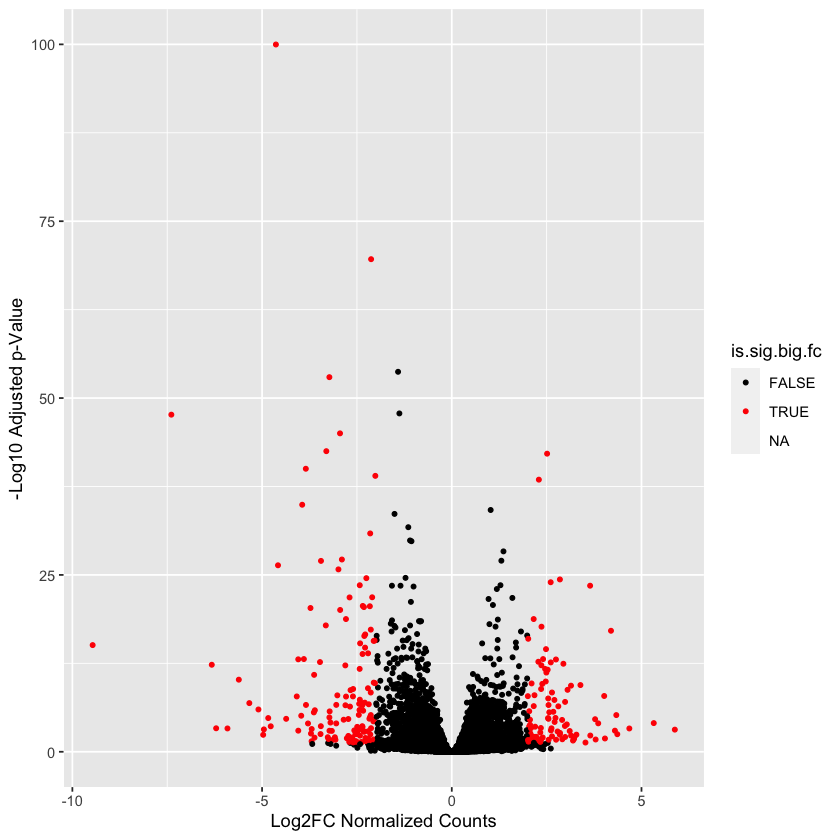

In [17]:
ggplot(result.dataframe, aes(x = log2FoldChange, y = neg.log10.padj, color = is.sig.big.fc)) +
    geom_point(size = 1) +
    scale_color_manual(values = c("black", "red")) +
    xlab("Log2FC Normalized Counts") +
    ylab("-Log10 Adjusted p-Value") 

In [18]:
sig.results.dataframe <- result.dataframe[result.dataframe$is.sig.big.fc,]
dim(sig.results.dataframe)

[1] 30121     9

In [19]:
sig.results.dataframe.filt <- sig.results.dataframe[-which(is.na(sig.results.dataframe$padj)),]
dim(sig.results.dataframe.filt)

[1] 240   9

---

## Using the `biomaRt` Library to Convert ENSEMBL Gene Identifiers to HSNC Gene Symbols 

### Import the Packages We'll be Using in this Portion of the Notebook

In [20]:
library("biomaRt")

### Create the `ENSEMBL` BioMart Object with the `useDataset()` and `useMart()` Methods

In [21]:
ensembl <- useDataset("hsapiens_gene_ensembl", useMart("ensembl", host="uswest.ensembl.org"))
ensembl

Object of class 'Mart':
  Using the ENSEMBL_MART_ENSEMBL BioMart database
  Using the hsapiens_gene_ensembl dataset

### Extract and Clean `ENSEMBL` Identifiers from our `DESeq2` Results with the `gsub()` Method

In [22]:
ensembl.ids <- rownames(sig.results.dataframe)

### Fetch Conversion Between `ENSEMBL` Identifiers and HGNC Symbols with the `getBM()` Method

In [23]:
# Before we fetch the gene list, let's enter these commands to 
# combat connection problems we might encounter when accessing biomart... 
# (From: https://www.bioconductor.org/packages/devel/bioc/vignettes/biomaRt/inst/doc/accessing_ensembl.html)
httr::set_config(httr::config(ssl_verifypeer = FALSE))
httr::set_config(httr::config(ssl_cipher_list = "DEFAULT@SECLEVEL=1"))

# Fetch the translation for our ENSEMBL IDs from BioMart to convert them to HGNC Symbols!
gene.list <- getBM(filters = 'ensembl_gene_id', 
                   attributes = c('ensembl_gene_id', 'hgnc_symbol'), # specifies columns we want from biomart
                   values = ensembl.ids, # provide the query for our search - which ENSEMBL IDs to look up
                   mart = ensembl)       # provide the biomart object we would like to use for our search

### Translate the `ENSEMBL` Identifiers in our `DESeq2` Database

In [24]:
rownames(sig.results.dataframe) <- ensembl.ids
filtered.sig.results.dataframe <- sig.results.dataframe[gene.list$ensembl_gene_id,]

rownames(filtered.sig.results.dataframe) <- make.names(gene.list$hgnc_symbol, unique = TRUE)
head(filtered.sig.results.dataframe)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,neg.log10.padj,is.sig,is.sig.big.fc
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
PDK4,900.629348,-2.580271,0.9028274,-2.857989,4.263352e-03,3.185304e-02,1.496849,TRUE,TRUE
MYH13,9.168718,-3.159259,1.0600216,-2.980373,2.878980e-03,2.347001e-02,1.629487,TRUE,TRUE
SLC7A14,261.090782,2.941371,0.3720969,7.904852,2.682512e-15,3.609140e-13,12.442596,TRUE,TRUE
NPC1L1,15.939100,2.642065,0.7709565,3.426996,6.102981e-04,6.633692e-03,2.178245,TRUE,TRUE
CHDH,91.160014,2.062430,0.4605594,4.478096,7.531159e-06,1.528324e-04,3.815784,TRUE,TRUE
CYP24A1,12.868257,4.299560,1.0796728,3.982281,6.825703e-05,1.040417e-03,2.982792,TRUE,TRUE
